https://rpubs.com/arquez9512/630415

# SMA

In [1]:
import numpy as np
import pandas as pd

#!wget -nc https://lazyprogrammer.me/course_files/sp500_close.csv
close = pd.read_csv('../datasets/sp500_close.csv', index_col=0, parse_dates=True)
close

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-05,49.76,156.4900,109.86,109.51,91.90,58.73,151.83,190.27,85.40,40.60,...,66.97,37.68,79.72,58.54,31.38,72.66,79.80,123.18,51.65,73.83
2018-02-06,51.18,163.0300,112.20,111.20,91.54,58.86,154.69,194.47,88.54,42.00,...,68.99,37.34,78.35,58.46,30.85,71.33,80.58,122.30,52.52,73.27


<AxesSubplot: >

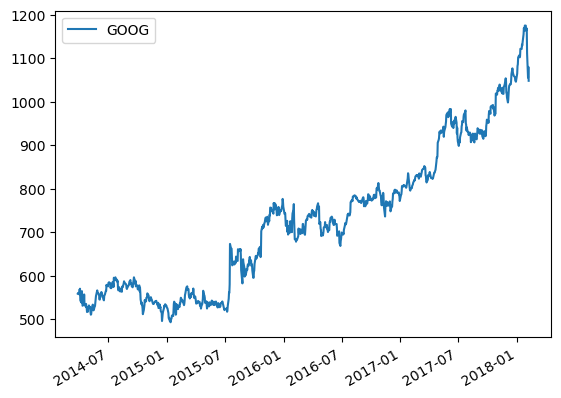

In [2]:
# copy google data
goog = close[['GOOG']].copy().dropna()
#goog.head()
goog.plot()


<AxesSubplot: >

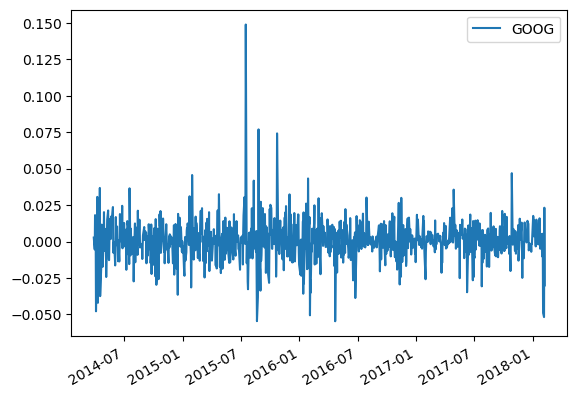

In [3]:
goog_ret = np.log(goog.pct_change(1) + 1) #pct_change: returns a DataFrame with the percentage difference between the values for each row and, by default, the previous row.
goog_ret.plot()

In [4]:
"""
SMA-> rolling: tamaño de la ventana,# de datos

      estadistica a considerar->mean  
"""

goog['SMA-10'] = goog['GOOG'].rolling(10).mean()
goog.head(20)

,GOOG,SMA-10
2014-03-27,558.46,NaN
2014-03-28,559.99,NaN
2014-03-31,556.97,NaN
2014-04-01,567.16,NaN
2014-04-02,567.00,NaN
2014-04-03,569.74,NaN
2014-04-04,543.14,NaN
2014-04-07,538.15,NaN
2014-04-08,554.90,NaN
2014-04-09,564.14,557.965


<AxesSubplot: >

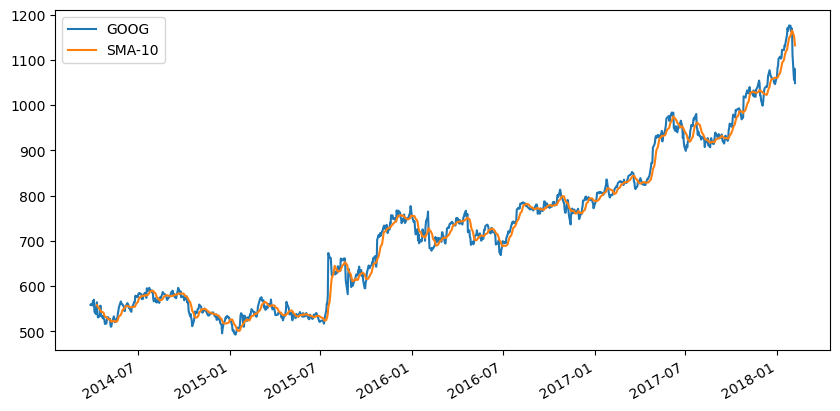

In [5]:
goog.plot(figsize=(10, 5))


<AxesSubplot: >

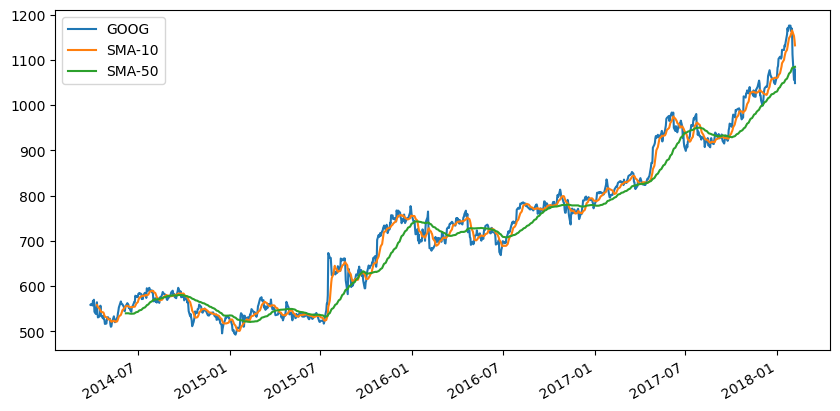

In [6]:
# mas suave, mientras mas valores se usen para promediar
goog['SMA-50'] = goog['GOOG'].rolling(50).mean()
goog.plot(figsize=(10, 5))

In [7]:
#Serie temporal multidimensional
goog_aapl = close[['GOOG', 'AAPL']].copy().dropna()
cov = goog_aapl.rolling(50).cov()
cov

GOOG       AAPL
2014-03-27 GOOG          NaN        NaN
           AAPL          NaN        NaN
2014-03-28 GOOG          NaN        NaN
           AAPL          NaN        NaN
2014-03-31 GOOG          NaN        NaN
...                      ...        ...
2018-02-05 AAPL    34.825709  17.568865
2018-02-06 GOOG  2691.756465  38.174468
           AAPL    38.174468  19.121371
2018-02-07 GOOG  2678.778214  49.980378
           AAPL    49.980378  22.052882

[1950 rows x 2 columns]

In [8]:
#Seleccionar una fecha y convertirl los datos  a un arreglo de
cov.loc['2018-02-07'].to_numpy()

array([[2678.77821424,   49.98037849],
       [  49.98037849,   22.05288249]])

In [9]:
#Log return
goog_aapl_ret = np.log(1 + goog_aapl.pct_change(1))
goog_aapl_ret.head()

,GOOG,AAPL
2014-03-27,NaN,NaN
2014-03-28,0.002736,-0.001117
2014-03-31,-0.005408,-0.000223
2014-04-01,0.018130,0.009106
2014-04-02,-0.000282,0.001661


In [10]:
#mas suave
goog_aapl_ret['GOOG-SMA-50'] = goog_aapl_ret['GOOG'].rolling(50).mean()
goog_aapl_ret['AAPL-SMA-50'] = goog_aapl_ret['AAPL'].rolling(50).mean()

<AxesSubplot: >

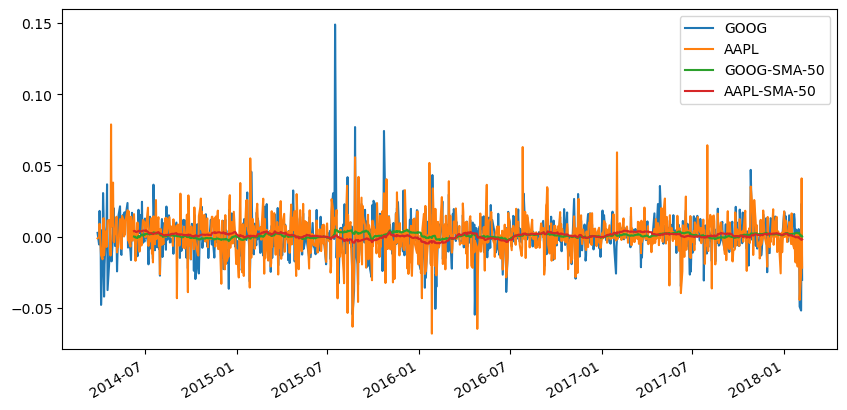

In [11]:
goog_aapl_ret.plot(figsize=(10, 5))

In [12]:
cov = goog_aapl_ret[['GOOG', 'AAPL']].rolling(50).cov()
cov.tail()

GOOG      AAPL
2018-02-05 AAPL  0.000110  0.000143
2018-02-06 GOOG  0.000193  0.000129
           AAPL  0.000129  0.000177
2018-02-07 GOOG  0.000212  0.000142
           AAPL  0.000142  0.000185

In [13]:
corr = goog_aapl_ret[['GOOG', 'AAPL']].rolling(50).corr()
corr.tail(16) #last 16

GOOG      AAPL
2018-01-29 GOOG  1.000000  0.531436
           AAPL  0.531436  1.000000
2018-01-30 GOOG  1.000000  0.525389
           AAPL  0.525389  1.000000
2018-01-31 GOOG  1.000000  0.515233
           AAPL  0.515233  1.000000
2018-02-01 GOOG  1.000000  0.510051
           AAPL  0.510051  1.000000
2018-02-02 GOOG  1.000000  0.671209
           AAPL  0.671209  1.000000
2018-02-05 GOOG  1.000000  0.681098
           AAPL  0.681098  1.000000
2018-02-06 GOOG  1.000000  0.700564
           AAPL  0.700564  1.000000
2018-02-07 GOOG  1.000000  0.716376
           AAPL  0.716376  1.000000

## EWMA

In [34]:
df = pd.read_csv('../datasets/AirPassengers.csv',  index_col = 'Month', parse_dates=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [35]:
df.isna().sum()


#Passengers    0
dtype: int64

<AxesSubplot: xlabel='Month'>

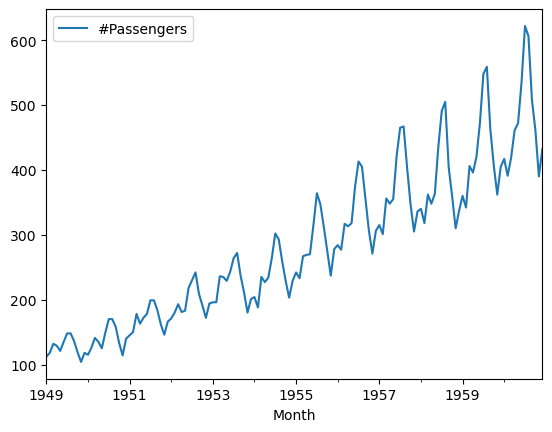

In [36]:
df.plot()


<AxesSubplot: xlabel='Month'>

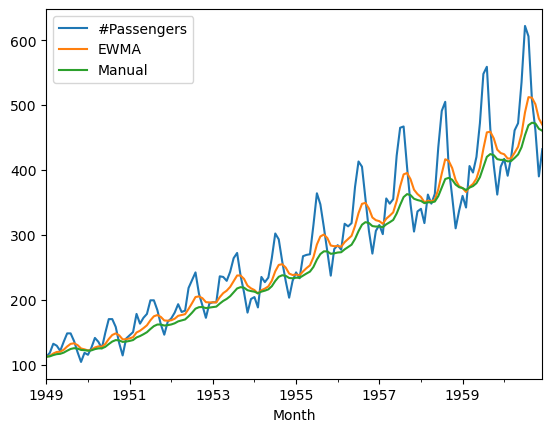

In [44]:
alpha = 0.2
df['EWMA'] = df['#Passengers'].ewm(alpha=alpha, adjust=False).mean()
df.plot()


<AxesSubplot: xlabel='Month'>

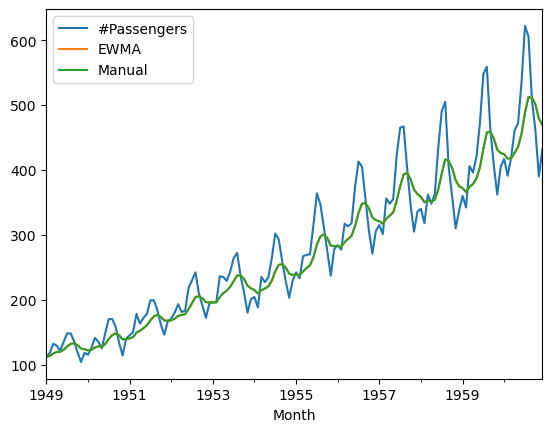

In [45]:
#Calcular EWMN manualmente
manual_ewma = []
for x in df['#Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma
df.plot()

In [39]:
df.drop('Manual', axis=1, inplace=True)


## Suaviamiento exponencial simple - SES (simple exponencial smoothing)

Este procedimiento es adecuado cuando los datos no tienen tendencia o patrón estacional. Los pesos de cada observación son determinados por un parametro de suavizamiento $\alpha$. Para un conjunto de datos con T
 observaciones , calculamos el valor predicho:

 \begin{equation}
 \hat{y}_{t+1} = \alpha y_t + \alpha(1-\alpha)y_{t-1}+\cdots+\alpha({1-\alpha})^{t-1}y_1
 \end{equation}

 Donde $0<\alpha <1$ puedes er visto como una tasa de aprendizaje. Valores cercanos a cero son considerados como aprendizaje lento ya que se da más peso a información histórica, mientra que valores cercanos a 1 son considerados como aprendizaje rápido porque el algoritmo da más peso a las observaciones recientes.

In [49]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [47]:
ses = SimpleExpSmoothing(df['#Passengers']) 


/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [20]:
df.index


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [21]:
# fijar la frecuencia mensualmente
df.index.freq = 'MS'

In [22]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [50]:
# optimizar alpha para ajustar a los datos
res = ses.fit(smoothing_level=alpha, optimized=False)
res 


In [52]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])
df['SES'] 

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Name: SES, Length: 144, dtype: float64

In [54]:
np.allclose(df['SES'], res.fittedvalues) #predict y fit son los mismos


True

<AxesSubplot: xlabel='Month'>

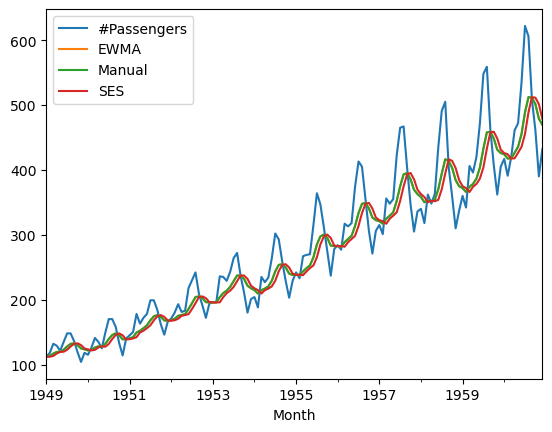

In [55]:
df.plot() #shift en 1


In [28]:
df.head()


,#Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [58]:
df['SES-1'] = df['SES'].shift(-1) #wrong 

<AxesSubplot: xlabel='Month'>

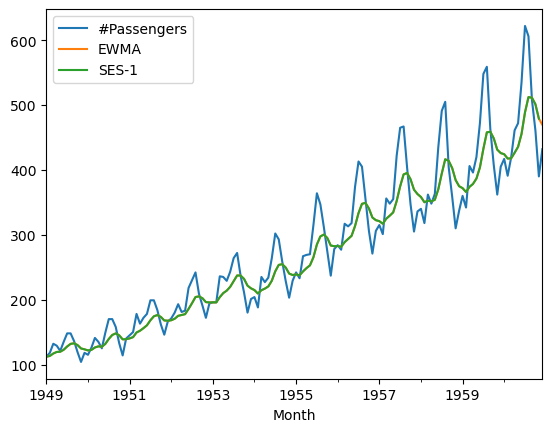

In [57]:
### No!
df[['#Passengers', 'EWMA', 'SES-1']].plot()

In [59]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [61]:
ses = SimpleExpSmoothing(
    train['#Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [62]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

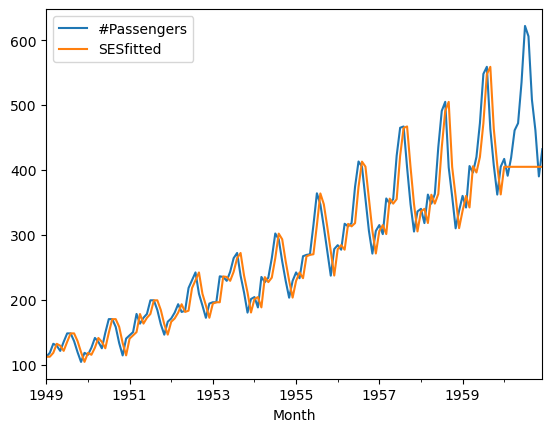

In [64]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['#Passengers', 'SESfitted']].plot();

In [65]:
res.params #casi 1 

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Holt

/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot: xlabel='Month'>

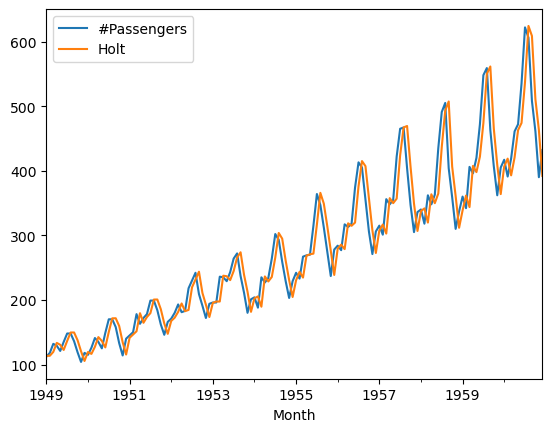

In [69]:
from statsmodels.tsa.holtwinters import Holt

holt = Holt(
    df['#Passengers'],
    initialization_method='legacy-heuristic')
res_h = holt.fit()
df['Holt'] = res_h.fittedvalues
df[['#Passengers', 'Holt']].plot()


/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot: xlabel='Month'>

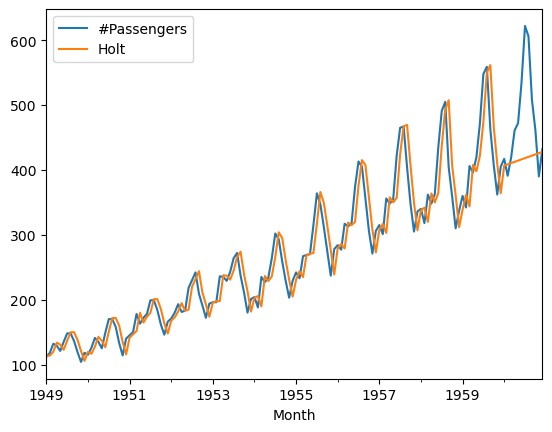

In [71]:
holt = Holt(train['#Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)
df[['#Passengers', 'Holt']].plot()

# Holt-Winter

/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot: xlabel='Month'>

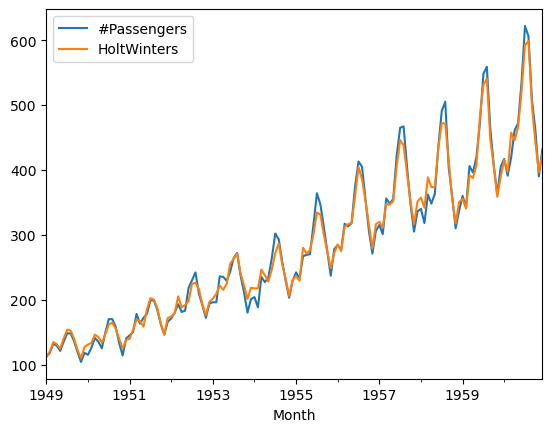

In [81]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Add
hw = ExponentialSmoothing(
    train['#Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['#Passengers', 'HoltWinters']].plot()

In [75]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))
def mae(y, t):
  return np.mean(np.abs(y - t))

In [77]:
print("Train RMSE:", rmse(train['#Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['#Passengers'], res_hw.forecast(N_test)))
print("Train MAE:", mae(train['#Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['#Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.624714430673352
Test RMSE: 16.978029847029934
Train MAE: 9.006650631052384
Test MAE: 13.37759090303536


/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot: xlabel='Month'>

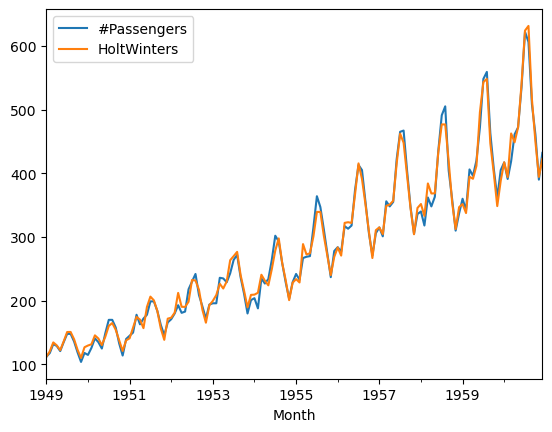

In [80]:
#Mult
hw = ExponentialSmoothing(
    train['#Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['#Passengers', 'HoltWinters']].plot()


In [82]:
print("Train RMSE:", rmse(train['#Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['#Passengers'], res_hw.forecast(N_test)))
print("Train MAE:", mae(train['#Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['#Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.624714430673352
Test RMSE: 16.978029847029934
Train MAE: 9.006650631052384
Test MAE: 13.37759090303536


/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<AxesSubplot: xlabel='Month'>

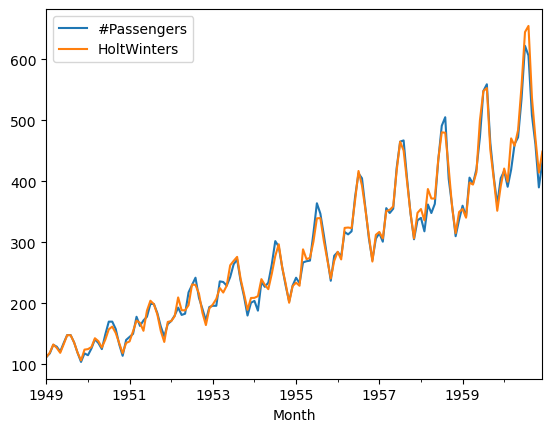

In [84]:
hw = ExponentialSmoothing(
    train['#Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['#Passengers', 'HoltWinters']].plot()

In [85]:
print("Train RMSE:", rmse(train['#Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['#Passengers'], res_hw.forecast(N_test)))
print("Train MAE:", mae(train['#Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['#Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.61792487803932
Test RMSE: 25.80687515735493
Train MAE: 7.112379992634933
Test MAE: 20.844988412204554
